In [1]:
import torch
import os
import applyllm as apl

print(apl.__version__)

0.0.6


In [2]:
if not torch.backends.mps.is_available():
    print("MPS is not available")
else:
    print("MPS is available")
    mps_device = torch.device("mps")
    print(mps_device)

MPS is available
mps


# Make image a live
https://huggingface.co/docs/diffusers/en/using-diffusers/svd

In [3]:
from applyllm.accelerators import (
    DirectorySetting,
    TokenHelper as th,
)
from applyllm.utils import time_func
    
dir_mode_map = {
    "kf_notebook": DirectorySetting(),
    "mac_local": DirectorySetting(home_dir="/Users/yingding", transformers_cache_home="MODELS", huggingface_token_file="MODELS/.huggingface_token"),
}

# https://huggingface.co/stabilityai/stable-video-diffusion-img2vid-xt
model_map = {
    "diffusion-img2vido-xt": "stabilityai/stable-video-diffusion-img2vid-xt",
}

default_model_type = "diffusion-img2vido-xt"
default_dir_mode = "mac_local"

dir_setting = dir_mode_map[default_dir_mode]

os.environ["WORLD_SIZE"] = "1" 
os.environ['XDG_CACHE_HOME'] = dir_setting.get_cache_home()

print(os.environ['XDG_CACHE_HOME'])

/Users/yingding/MODELS


In [4]:
import diffusers

print(diffusers.__version__)
print(torch.__version__)

0.29.2
2.3.1


In [5]:
model_type = "diffusion-img2vido-xt"

model_name = model_map.get(model_type, default_model_type)
print(model_name)

stabilityai/stable-video-diffusion-img2vid-xt


In [6]:
from applyllm.pipelines import (
    ModelCatalog,
    KwargsBuilder
)
token_kwargs = th.gen_token_kwargs(model_type=model_type, dir_setting=dir_setting)
print(f"token_kwargs: {token_kwargs}")

# data_type = torch.bfloat16
data_type = torch.float16
variant = "fp16"
device_map = "mps"
# auto caste not working for mps 4.38.2
# https://github.com/huggingface/transformers/issues/29431 

model_kwargs = {
    "torch_dtype": data_type, #bfloat16 is not supported on MPS backend, float16 only on GPU accelerator
    "variant": variant,
    "pretrained_model_name_or_path": model_name,
}
print(f"model_kwargs: {model_kwargs}")

huggingface token is NOT needed
token_kwargs: {}
model_kwargs: {'torch_dtype': torch.float16, 'variant': 'fp16', 'pretrained_model_name_or_path': 'stabilityai/stable-video-diffusion-img2vid-xt'}


## Use StableVideoDiffusion Pipeline on MPS

Note: 
* Can not load the pipeline with `device_map='auto'`
* Need to manually move the cpu pipeline to GPU device `pipe = pipe.to("mps")`

* https://huggingface.co/docs/diffusers/en/using-diffusers/svd


<class 'PIL.Image.Image'>
<class 'PIL.PngImagePlugin.PngImageFile'>


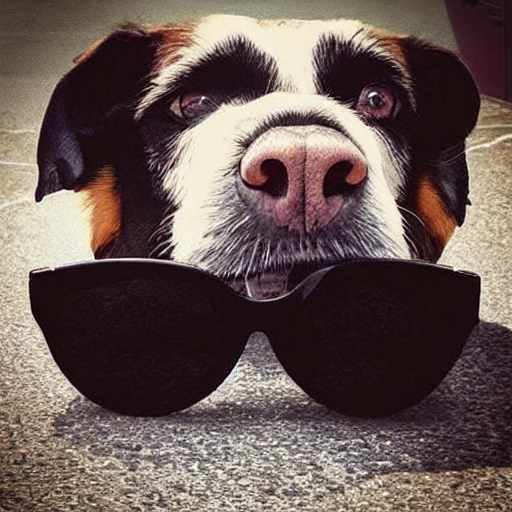

In [7]:
from diffusers.utils import load_image, export_to_video
from PIL import Image

video_dir = "video"
os.makedirs(video_dir, exist_ok=True)

video_type =".mp4"
img_type = ".png"
file_name = "dog_sunglasses"
img_file_path = f"./imgs/{file_name}{img_type}"
image = load_image(img_file_path)
image = image.resize((1024, 576))

print(type(image))

# reload and display the image file from the variable img_file_path in the Jupyter notebook cell inline
img = Image.open(img_file_path)
print(type(img))
# show inline
display(img)



## Torch Inductor doesn't support MPS

* https://github.com/pytorch/pytorch/issues/125254
* https://github.com/triton-lang/triton/issues/1057

In [8]:
from diffusers import StableVideoDiffusionPipeline

pipe = StableVideoDiffusionPipeline.from_pretrained(**model_kwargs)
pipe = pipe.to(device_map)
pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)
# pipe.enable_model_cpu_offload()

# prompt = "a photo of an astronaut riding a horse on mars"
generator = torch.manual_seed(42)

@time_func
def video_gen(img):
    return pipe(img, decode_chunk_size=8, generator=generator).frames[0]

frames = video_gen(image)


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

BackendCompilerFailed: backend='inductor' raised:
AssertionError: Device mps not supported

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [ ]:
video_file_path = f"./{video_dir}/{file_name}{video_type}"
export_to_video(frames, video_file_path, fps=7)